# Topic Modeling: Latent Dirichlet Allocation with gensim

Gensim is a specialized NLP library with a fast LDA implementation and many additional features. We will also use it in the next chapter on word vectors (see the notebook lda_with_gensim for details.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import pandas as pd

# Visualization
import seaborn as sns
import pyLDAvis

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import joblib

# gensim for alternative models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

In [3]:
sns.set_style('white')
pyLDAvis.enable_notebook()

## Load BBC data

In [4]:
# change to your data path if necessary
DATA_DIR = Path('../data')

In [5]:
path = DATA_DIR / 'bbc'
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [6]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


## Create Train & Test Sets

In [7]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [8]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [9]:
pd.Series(test_docs.topic).value_counts()

topic
Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: count, dtype: int64

### Vectorize train & test sets

In [11]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names_out()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178873 stored elements in Compressed Sparse Row format>

In [12]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 3890 stored elements in Compressed Sparse Row format>

## LDA with gensim

### Using `CountVectorizer` Input

In [18]:
max_df = .2
min_df = 3
max_features = 2000

# used by sklearn: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None).squeeze().tolist()

In [19]:
vectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words='english', 
                             max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.article)
test_dtm = vectorizer.transform(test_docs.article)

### Convert sklearn DTM to gensim data structures

It faciltiates the conversion of DTM produced by sklearn to gensim data structures as follows:

In [21]:
train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)
id2word = pd.Series(vectorizer.get_feature_names_out()).to_dict()

### Train Model & Review Results

In [22]:
LdaModel(corpus=train_corpus, 
         num_topics=100, 
         id2word=None, 
         distributed=False, 
         chunksize=2000,                   # Number of documents to be used in each training chunk.
         passes=1,                         # Number of passes through the corpus during training
         update_every=1,                   # Number of docs to be iterated through for each update
         alpha='symmetric', 
         eta=None,                         # a-priori belief on word probability
         decay=0.5,                        # percentage of previous lambda forgotten when new document is examined
         offset=1.0,                       # controls slow down of the first steps the first few iterations.
         eval_every=10,                    # estimate log perplexity
         iterations=50,                    # Maximum number of iterations through the corpus
         gamma_threshold=0.001,            # Minimum change in the value of the gamma parameters to continue iterating
         minimum_probability=0.01,         # Topics with a probability lower than this threshold will be filtered out
         random_state=None, 
         ns_conf=None, 
         minimum_phi_value=0.01,           # if `per_word_topics` is True, represents lower bound on term probabilities
         per_word_topics=False,            #  If True, compute a list of most likely topics for each word with phi values multiplied by word count
         callbacks=None);

In [23]:
num_topics = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, num_topics+1)]

In [24]:
lda_gensim = LdaModel(corpus=train_corpus,
                      num_topics=num_topics,
                      id2word=id2word)

In [25]:
topics = lda_gensim.print_topics()
topics[0]

(0,
 '0.013*"best" + 0.009*"film" + 0.006*"music" + 0.005*"british" + 0.005*"online" + 0.005*"band" + 0.005*"game" + 0.004*"won" + 0.004*"award" + 0.004*"awards"')

### Evaluate Topic Coherence

Topic Coherence measures whether the words in a topic tend to co-occur together. 

- It adds up a score for each distinct pair of top ranked words. 
- The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word.

Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often.

In [26]:
coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')

Gensim permits topic coherence evaluation that produces the topic coherence and shows the most important words per topic: 

  Topic 1          Topic 2          Topic 3           Topic 4         Topic 5          
     prob     term    prob     term    prob      term    prob    term    prob      term
0   0.67%     game   1.28%     best   0.68%      lord   0.81%  labour   0.54%    united
1   0.64%     play   0.90%     film   0.52%     games   0.67%  mobile   0.40%    glazer
2   0.50%      win   0.56%    music   0.43%      firm   0.58%   phone   0.38%  expected
3   0.44%  players   0.54%  british   0.43%      game   0.49%     tax   0.37%      home
4   0.40%      old   0.50%   online   0.42%  election   0.47%   party   0.36%      club


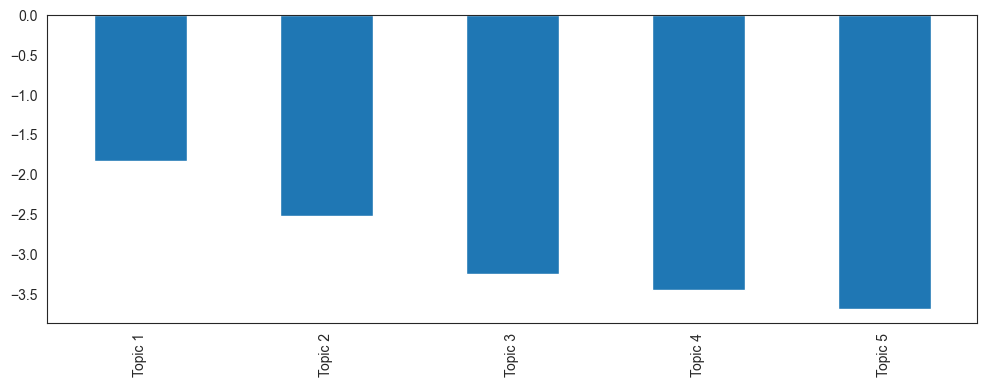

In [27]:
topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
topic_words.head().to_csv('topic_words.csv', index=False)
print(topic_words.head())

pd.Series(topic_coherence, index=topic_labels).plot.bar(figsize=(12,4));

### Using `gensim` `Dictionary` 

In [28]:
docs = [d.split() for d in train_docs.article.tolist()]
docs = [[t for t in doc if t not in stop_words] for doc in docs]

In [29]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

In [30]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [31]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 2175


In [32]:
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = None # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [33]:
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes, 
                 eval_every=eval_every)

In [34]:
model.show_topics()

[(0,
  '0.012*"government" + 0.012*"Labour" + 0.009*"Blair" + 0.009*"public" + 0.008*"Brown" + 0.007*"election" + 0.006*"say" + 0.006*"minister" + 0.006*"Lord" + 0.006*"party"'),
 (1,
  '0.009*"market" + 0.007*"company" + 0.007*"growth" + 0.007*"economic" + 0.006*"sales" + 0.006*"economy" + 0.006*"chief" + 0.006*"rise" + 0.006*"firm" + 0.006*"oil"'),
 (2,
  '0.009*"used" + 0.009*"use" + 0.009*"mobile" + 0.008*"phone" + 0.008*"technology" + 0.007*"using" + 0.006*"users" + 0.006*"service" + 0.006*"information" + 0.005*"work"'),
 (3,
  '0.010*"game" + 0.008*"win" + 0.007*"play" + 0.007*"England" + 0.006*"good" + 0.006*"second" + 0.006*"think" + 0.006*"world" + 0.006*"won" + 0.005*"it\'s"'),
 (4,
  '0.018*"music" + 0.017*"best" + 0.016*"film" + 0.010*"TV" + 0.010*"digital" + 0.010*"games" + 0.009*"video" + 0.008*"UK" + 0.006*"won" + 0.006*"director"')]

### Evaluating Topic Assignments on the Test Set

In [35]:
docs_test = [d.split() for d in test_docs.article.tolist()]
docs_test = [[t for t in doc if t not in stop_words] for doc in docs_test]

test_dictionary = Dictionary(docs_test)
test_dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)
test_corpus = [dictionary.doc2bow(doc) for doc in docs_test]

In [36]:
gamma, _ = model.inference(test_corpus)
topic_scores = pd.DataFrame(gamma)
topic_scores.head(10)

,0,1,2,3,4
0,0.117415,58.790367,48.749126,16.074173,33.803864
1,5.957569,0.112531,96.418823,0.130367,12.926271
2,0.117366,0.112540,29.211622,38.541729,89.552147
3,1.241930,61.105839,6.989633,0.130243,0.085728
4,2.554932,0.112552,0.128213,73.627411,10.125678
5,7.984490,51.269672,8.088428,0.130348,0.085728
6,10.665106,43.864391,6.478320,17.247799,2.293339
7,6.045420,0.112523,0.128169,74.186638,0.085732
8,15.337703,47.879017,0.128292,0.130298,0.085729
9,0.117397,44.287113,0.128438,2.939726,0.085730


In [37]:
topic_probabilities = topic_scores.div(topic_scores.sum(axis=1), axis=0)
topic_probabilities.head()

,0,1,2,3,4
0,0.000745,0.373189,0.309450,0.102036,0.214580
1,0.051560,0.000974,0.834466,0.001128,0.111872
2,0.000745,0.000714,0.185429,0.244654,0.568457
3,0.017856,0.878546,0.100493,0.001873,0.001233
4,0.029520,0.001300,0.001481,0.850704,0.116994


In [38]:
topic_probabilities.idxmax(axis=1).head()

0    1
1    2
2    4
3    1
4    3
dtype: int64

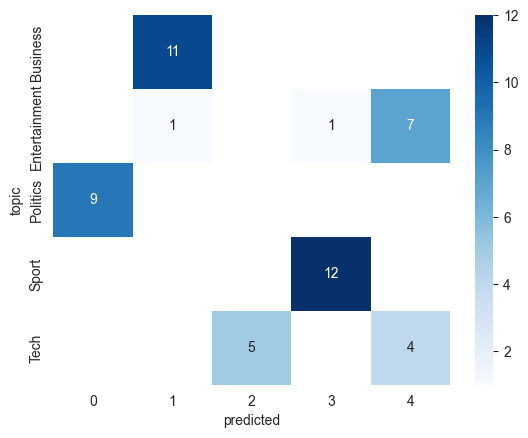

In [39]:
predictions = test_docs.topic.to_frame('topic').assign(predicted=topic_probabilities.idxmax(axis=1).values)
heatmap_data = predictions.groupby('topic').predicted.value_counts().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='Blues');

## Resources

- pyLDAvis: 
    - [Talk by the Author](https://speakerdeck.com/bmabey/visualizing-topic-models) and [Paper by (original) Author](http://www.aclweb.org/anthology/W14-3110)
    - [Documentation](http://pyldavis.readthedocs.io/en/latest/index.html)
- LDA:
    - [David Blei Homepage @ Columbia](http://www.cs.columbia.edu/~blei/)
    - [Introductory Paper](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf) and [more technical review paper](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf)
    - [Blei Lab @ GitHub](https://github.com/Blei-Lab)
    
- Topic Coherence:
    - [Exploring Topic Coherence over many models and many topics](https://www.aclweb.org/anthology/D/D12/D12-1087.pdf)
    - [Paper on various Methods](http://www.aclweb.org/anthology/N10-1012)
    - [Blog Post - Overview](http://qpleple.com/topic-coherence-to-evaluate-topic-models/)
